In [1]:
### Ref: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For basic Image IO
import IPython.display as display
from PIL import Image

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def make_dirs(path, clean=False):
    if not os.path.exists(path):
        os.makedirs(path)
    else: #Empty the directory
        if clean == True:
            shutil.rmtree(path)
    return
    

#Add basic logging
import logging     
make_dirs("logs/events")
logging.basicConfig(filename=os.path.join("logs/events",'cs230_keras_notebook.log'),
                    level=logging.DEBUG,
                   format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p')

#Load Extensions
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

import transfer_learning

Using TensorFlow backend.


In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def show_batch(image_batch, label_batch, class_indices):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        label_indices = np.argmax(label_batch[n])
        
        #Flip the dictionary from class_indices to indices_class
        indices_class = dict((v,k) for k, v in class_indices.items()) 
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.title(indices_class.get(label_indices))
        plt.axis('off')

In [6]:
def show_batch_grayscale(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap='gray',interpolation='none')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [7]:
#This assumed that you have checked out the data repo next to the object detection repo
# Data repo can be found over here: https://github.com/nandini-sundar/CS230-TrashNet-YOLO-Labeled
import pathlib
data_dir = pathlib.Path("../CS230-TrashNet-YOLO-Labeled")

In [8]:
class_names_file = data_dir.joinpath("classes.txt")
class_names = pd.read_csv(class_names_file, header = None, sep='\n', names=['classes'])
print(class_names.values)
n_classes = len(class_names)
print(n_classes)

[['glass']
 ['metal']
 ['plastic']
 ['cardboard']
 ['trash']
 ['paper']]
6


In [9]:
import shutil

data_images_dir = data_dir.joinpath("Images")
CLASS_NAMES = np.array([item.name for item in data_images_dir.glob('*') if item.name != "LICENSE.txt"])

CLASS_NAMES

#Make directory to save generated images
generated_train_images_dir = data_dir.joinpath("generated/train")
generated_validation_images_dir = data_dir.joinpath("generated/validation")
generated_test_images_dir = data_dir.joinpath("generated/test")
if not os.path.exists(generated_train_images_dir):
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
else: #Empty the directory
    shutil.rmtree(generated_train_images_dir)
    shutil.rmtree(generated_validation_images_dir)
    shutil.rmtree(generated_test_images_dir)
    
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
    
logging.info("Generated train images stored at {}".format(generated_train_images_dir))
logging.info("Generated validation images stored at {}".format(generated_validation_images_dir))
logging.info("Generated test images stored at {}".format(generated_test_images_dir))

In [10]:
image_count = len(list(data_images_dir.glob('*/*.jpg')))
print("Total number of input images {}".format(image_count))

Total number of input images 2527


In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
def get_dataframe_for_generator(filename, x_col, y_col):
    df = pd.read_csv(data_dir.joinpath(filename), names=[x_col])
    
    #Convert foldernames in filepaths to class names.
    #Expects filepath in format : ./Images/paper/paper283.jpg
    df[y_col] = df[x_col].apply(lambda x: os.path.basename(os.path.dirname(x)))
    
    return df
    
x_col = "filename"
y_col = 'class_list'

train_df = get_dataframe_for_generator(filename='train.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some train images ")
logging.debug(train_df)

test_df = get_dataframe_for_generator(filename='test.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some test images ")
logging.debug(test_df)

In [13]:
def split_and_join(s, repl):
    splits = str.split(s, '/')
    splits[1] = repl
    return "/".join(splits)

In [14]:
train_df['label_path']  = train_df[x_col].str.replace(pat='.jpg', repl='.txt')
train_df['label_path'] = train_df['label_path'].apply(lambda x: split_and_join(x, 'Labels'))

In [15]:
train_df

,filename,class_list,label_path
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt
...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt


In [16]:
#train_df['label_path'].apply(lambda label_path : pd.read_csv(data_dir.joinpath(label_path) ))
label_format = ['class_id', 'x', 'y', 'w', 'h']

labels_list = []
for label_file in train_df['label_path']:
    label_file = data_dir.joinpath(label_file)
    df_label_indiv = pd.read_csv(label_file, sep=" ", names=label_format)
    
    #Keeping only first row of the dataframe for simplicity
    df_label_indiv = df_label_indiv.head(1)
    labels_list.append(df_label_indiv)

df_label_all = pd.concat(labels_list)
df_label_all.reset_index(drop=True, inplace=True)
#print(df_label_all)

df_label_all.index = train_df.index
train_df_x_y = pd.concat([train_df, df_label_all], axis=1, sort=False)
train_df_x_y

,filename,class_list,label_path,class_id,x,y,w,h
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt,5,0.503906,0.519531,0.992188,0.966146
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt,5,0.467773,0.503906,0.916016,0.986979
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt,5,0.453125,0.503906,0.890625,0.981771
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt,5,0.393555,0.585938,0.775391,0.828125
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt,5,0.550781,0.503906,0.894531,0.955729
...,...,...,...,...,...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt,2,0.501953,0.505208,0.988281,0.989583
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt,2,0.689453,0.613281,0.617188,0.648438
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt,2,0.490234,0.404948,0.523438,0.695312
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt,2,0.588867,0.605469,0.365234,0.789062


In [17]:
def deconvert(yolobox, img_width,img_height ):
    
    ox = float(yolobox[0])
    oy = float(yolobox[1])
    ow = float(yolobox[2])
    oh = float(yolobox[3])
    x = ox*img_width
    y = oy*img_height
    w = ow*img_width
    h = oh*img_height
    xmax = (((2*x)+w)/2)
    xmin = xmax-w
    ymax = (((2*y)+h)/2)
    ymin = ymax-h
    print(xmin, ymin, xmax, ymax)
    return int(xmin),int(xmax),int(ymin),int(ymax)

In [18]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 validation_split=0.25,
                                                                 rotation_range=180,
                                                                 shear_range=0.5,
                                                                  zoom_range=0.9,
                                                                  horizontal_flip=True,
                                                                 vertical_flip=True,
                                                                  width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                 fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=data_dir.joinpath("train/Images"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_train_images_dir,
                                                     subset="training",
                                                    save_prefix="gen-")

Found 1714 images belonging to 6 classes.


In [19]:
validation_generator= train_datagen.flow_from_directory(directory=data_dir.joinpath("train/Images"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_validation_images_dir,
                                                     subset="validation",
                                                    save_prefix="gen-")

Found 569 images belonging to 6 classes.


In [20]:
#Notice that y_col = None
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=data_dir.joinpath("test/Images"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                   class_mode='categorical', 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    save_to_dir=generated_test_images_dir,
                                                    save_prefix="gen-")

Found 244 images belonging to 6 classes.


image_batch_shape (32, 224, 224, 3)


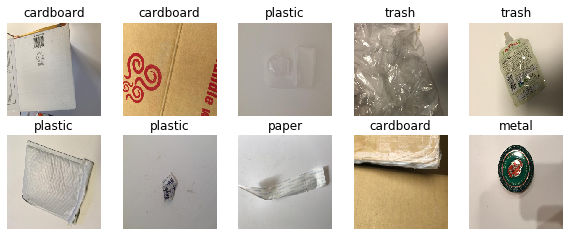

In [21]:
image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch, test_generator.class_indices)

image_batch_shape (32, 224, 224, 3)


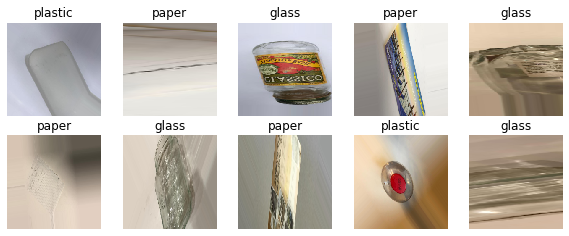

In [22]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, train_generator.class_indices)

In [23]:
BASE_EPOCHS=5
FINE_TUNE_EPOCHS=50

xception_base_model = keras.applications.xception.Xception(weights='imagenet',include_top = False)
transfer_xception = transfer_learning.transfer_learning(name="xception", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS,
                                                        image_path = IMAGES_PATH)

transfer_xception.train_generator(xception_base_model, train_generator, validation_generator)

vgg16_base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
transfer_vgg16 = transfer_learning.transfer_learning(name="vgg16", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS)

transfer_vgg16.train_generator(vgg16_base_model, train_generator, validation_generator)


In [ ]:
resnet50_base_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet' )
transfer_resnet50 = transfer_learning.transfer_learning(name="resnet50", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS,
                                                        image_path = IMAGES_PATH)

transfer_resnet50.train_generator(resnet50_base_model, train_generator, validation_generator)


Freezing all base layers
Epoch 1/5
53/53 [==============================] - 18s 347ms/step - loss: 1.9337 - accuracy: 0.5612 - val_loss: 3.1271 - val_accuracy: 0.4991
Epoch 2/5
53/53 [==============================] - 18s 334ms/step - loss: 1.6711 - accuracy: 0.6540 - val_loss: 4.1025 - val_accuracy: 0.4306
Epoch 3/5
53/53 [==============================] - 18s 331ms/step - loss: 1.6726 - accuracy: 0.6671 - val_loss: 3.3338 - val_accuracy: 0.5343
Epoch 4/5
53/53 [==============================] - 18s 333ms/step - loss: 1.5880 - accuracy: 0.6730 - val_loss: 3.7402 - val_accuracy: 0.5167
Epoch 5/5
53/53 [==============================] - 17s 317ms/step - loss: 1.4843 - accuracy: 0.7105 - val_loss: 3.5184 - val_accuracy: 0.5677
Unfreezing all base layers
Epoch 1/50
53/53 [==============================] - 22s 420ms/step - loss: 3.0505 - accuracy: 0.3365 - val_loss: 12.8486 - val_accuracy: 0.2039
Epoch 2/50
53/53 [==============================] - 23s 437ms/step - loss: 1.9934 - accuracy: 

In [ ]:
plt.plot(transfer_resnet50.history.epoch,transfer_resnet50.history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, FINE_TUNE_EPOCHS - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(transfer_resnet50.history.epoch, transfer_resnet50.history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


transfer_resnet50.evaluate(test_gen=test_generator, load_best=True)

In [ ]:
y_pred = transfer_resnet50.model.predict_generator(test_generator)

In [ ]:
np.argmax(y_pred, axis=1) 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(test_generator.classes, y_pred.argmax(axis=1))
matrix

In [ ]:
test_generator.class_indices

In [ ]:
target_names = list(test_generator.class_indices.keys())

In [ ]:
y_true = test_generator.classes
report = classification_report(y_true, y_pred.argmax(axis=1), target_names=target_names, output_dict=True)
print(report)

In [ ]:
from tabulate import tabulate
class_report = pd.DataFrame(report)
print(class_report.columns)
print(tabulate(class_report, tablefmt="latex", floatfmt=".2f"))

In [ ]:
print(class_report.to_latex())

In [ ]:
image_batch, label_batch = next(test_generator)
transfer_resnet50.model.predict(image_batch)

In [ ]:
mobileNet_base_model= keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet')
transfer_mobileNet = transfer_learning.transfer_learning(name="mobilenet", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS)

transfer_mobileNet.train_generator(mobileNet_base_model, train_generator, validation_generator)


In [ ]:
densenet121_base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet' )
transfer_densenet = transfer_learning.transfer_learning(name="densenet", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS)

transfer_densenet.train_generator(densenet121_base_model, train_generator, validation_generator)

In [ ]:
NASNet_base = keras.applications.nasnet.NASNetMobile(include_top=False, weights='imagenet' )
transfer_NASNet = transfer_learning.transfer_learning(name="NASNet", n_classes=n_classes, 
                                    batch_size=BATCH_SIZE, 
                                    base_epochs=BASE_EPOCHS, 
                                    tune_epochs=FINE_TUNE_EPOCHS)

transfer_NASNet.train_generator(NASNet_base, train_generator, validation_generator)

In [ ]:
pd.DataFrame(transfer_NASNet.__).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
input_shape = (384, 512, 1)
print("Input shape {}".format(input_shape))
model_input = tf.keras.Input(shape=input_shape, name='Foreground')
x = tf.keras.layers.MaxPooling2D(pool_size=(5,5))(model_input)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(inputs=model_input, outputs=outputs, name='mnist_model')


model.compile(loss= tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.1),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.save("Optimization_model.h5")

In [ ]:
def get_model(base_model):
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    reg = keras.layers.BatchNormalization()(avg)
    class_output = keras.layers.Dense(n_classes, activation="softmax")(reg)
    model = keras.models.Model(inputs=base_model.input,outputs=[class_output])
    return model

In [ ]:
def transfer_learn(base_model, model, train_gen, validation_gen):
    #Let the training settle
    print("Freezing all base layers")
    for layer in base_model.layers:
        layer.trainable = False
    
    adam = tf.keras.optimizers.Adam(lr=0.01) #Higher lerarning rate
    model.compile(adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    history = model.fit_generator(train_generator, epochs=1, workers=8,
                                  steps_per_epoch=train_gen.samples // BATCH_SIZE,
                                  shuffle=True,
                                  validation_data=validation_gen,
                                  callbacks = callback_list)
    
    #Unfreeze the layers from the base model
    print("Unfreezing all base layers")
    for layer in base_model.layers:
        layer.trainable = True
    
    adam = tf.keras.optimizers.Adam(lr=0.000001) #Lower the lerarning rate lerarning rate
    model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit_generator(train_generator, epochs=2, workers=8,
                                  steps_per_epoch=train_gen.samples // BATCH_SIZE,
                                  shuffle=True,
                                  validation_data=validation_gen,
                                  callbacks=[tensorboard_cb,checkpoint_cb,reduce_lr_cb,csv_logger_cb])
    
    return model, history
    

In [ ]:
def evaluate(model, test_gen):
    return model.evaluate_generator(test_gen, test_gen.samples//BATCH_SIZE, callbacks=callback_list)

In [ ]:
def train(base_model, train_gen, validation_gen, test_generator):
    work_model = get_model(base_model)
    work_model, work_model_history = transfer_learn(base_model, work_model, train_gen, validation_gen )
    loss, accuracy = evaluate(work_model, test_data_gen)
    print("Test accuracy is: {}".format(accuracy))
    return work_model, work_model_history, loss, accuracy

In [ ]:
xception_base_model = keras.applications.xception.Xception(weights='imagenet',include_top = False)
xception, xception_history, xception_loss, xception_accuracy = train(xception_base_model,train_generator, validation_data_gen, test_data_gen )

In [ ]:
vgg16_base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
vgg16, vgg16_history, vgg16_loss, vgg16_accuracy =  train(vgg16_base_model, train_generator, validation_data_gen, test_data_gen )

In [ ]:
vgg19_base_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg19, vgg19_history, vgg19_loss, vgg19_accuracy =  train(vgg19_base_model, train_generator, validation_data_gen, test_data_gen )

In [ ]:
resnet50_base_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet' )
resnet50, resnet50_history, resnet50_loss, resnet50_accuracy =  train(resnet50_base_model, train_generator, validation_data_gen, test_data_gen )

In [ ]:

# keras.applications.resnet.ResNet101(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
# keras.applications.resnet.ResNet152(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
# keras.applications.resnet_v2.ResNet50V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
# keras.applications.resnet_v2.ResNet101V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
# keras.applications.resnet_v2.ResNet152V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [ ]:
train_generator.class_indices

In [ ]:
indices_class = dict((v,k) for k, v in train_generator.class_indices.items())

In [ ]:
print(indices_class)

In [ ]:
show_batch(image_batch, label_batch, train_generator.class_indices)

In [ ]:
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

In [ ]:
import cv2

def generate_data(df, x_col, dir_path ):
    X_data = []
    for f in df[x_col]:
        f = dir_path.joinpath(f)
        f = str(f)
        img = cv2.imread(f)
        img_resized = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        norm_image = cv2.normalize(img_resized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        X_data.append(norm_image)
        
    X_data = np.array(X_data)
    #X_data = X_data / 255
    return X_data
 

X_data = generate_data(df=train_df_x_y, x_col=x_col, dir_path=data_dir )

In [ ]:
X_data

In [ ]:
## Load output y_class_output
class_output = train_df_x_y[label_format[0]].tolist()
y_class_output = tf.keras.utils.to_categorical(class_output, n_classes )
y_class_output

In [ ]:
n_classes

In [ ]:
def train_validation_test_split(X, y, test_size=0.25, validation_size=0.25):
    import numpy as np
    from sklearn.model_selection import train_test_split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test
    

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_validation_test_split(X=X_data, y=y_class_output, test_size=0.25, validation_size=0.25)

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=2, workers=8, 
                                       shuffle=True,
                            validation_data=(X_valid, y_valid),
                             callbacks = callback_list)

In [ ]:
len(X_train)//BATCH_SIZE

In [ ]:
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

hypermodel = HyperResNet(input_shape=(224, 224, 3), num_classes=6)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    directory='my_dir',
    project_name='my_trashnet')

tuner.search_(X_train, y_train,
             epochs=20,
             validation_data=(X_valid, y_valid))